C:\ProgramData\anaconda3\envs\flower_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
	Instead, use the `flower-superlink` CLI command to start a SuperLink as shown below:

		$ flower-superlink --insecure

	To view usage and all available options, run:

		$ flower-superlink --help

	Using `start_server()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower server, config: num_rounds=3, no round_timeout


✅ Imports loaded. Ready to run server code.
✅ Strategy defined.
🚀 Starting Flower Server...


INFO :      Flower ECE: gRPC server running (3 rounds), SSL is disabled
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


✅ Round 1: Saving final aggregated parameters...


INFO :      aggregate_evaluate: received 2 results and 0 failures



--- Results from Client 1 (640 examples) ---
  Loss: 0.8700
  Accuracy: 0.5453


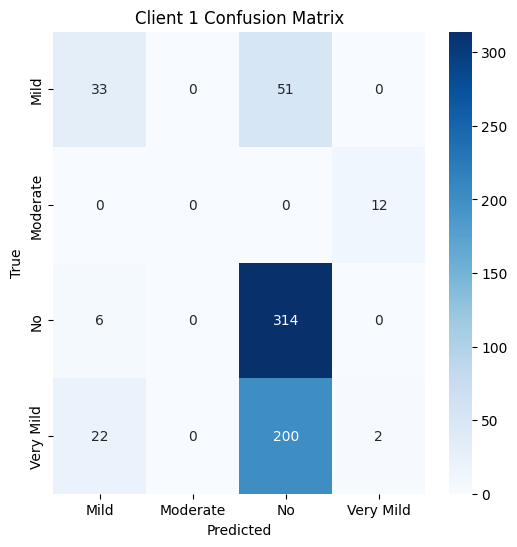


--- Results from Client 2 (643 examples) ---
  Loss: 0.8895
  Accuracy: 0.5350


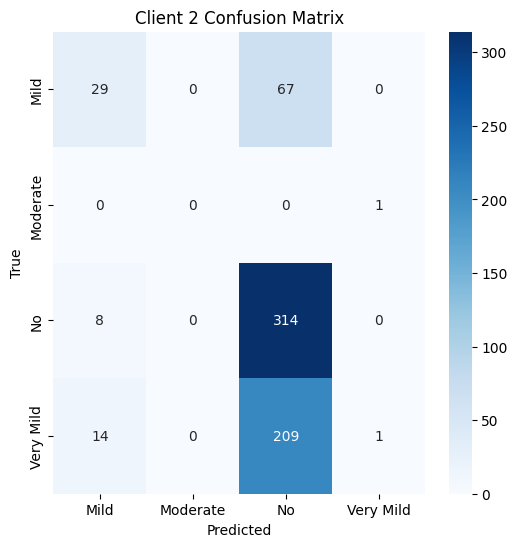

INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)



📊 Round 1 AGGREGATED: loss=0.8798, acc=0.5401, time=33.37s


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


✅ Round 2: Saving final aggregated parameters...


INFO :      aggregate_evaluate: received 2 results and 0 failures



--- Results from Client 1 (643 examples) ---
  Loss: 0.6375
  Accuracy: 0.6796


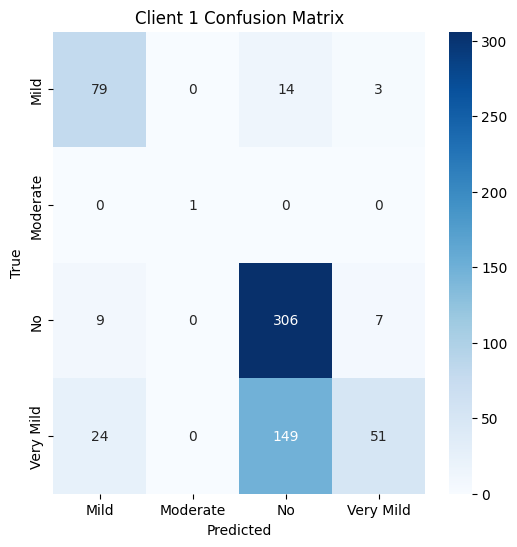


--- Results from Client 2 (640 examples) ---
  Loss: 0.5880
  Accuracy: 0.7312


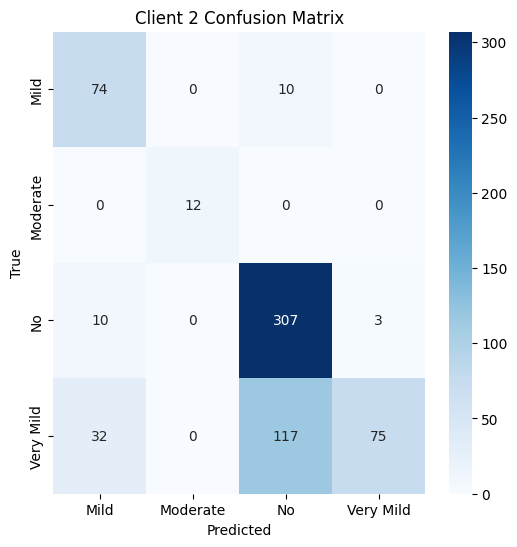

INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)



📊 Round 2 AGGREGATED: loss=0.6128, acc=0.7054, time=25.97s


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


✅ Round 3: Saving final aggregated parameters...


INFO :      aggregate_evaluate: received 2 results and 0 failures



--- Results from Client 1 (643 examples) ---
  Loss: 0.3896
  Accuracy: 0.8445


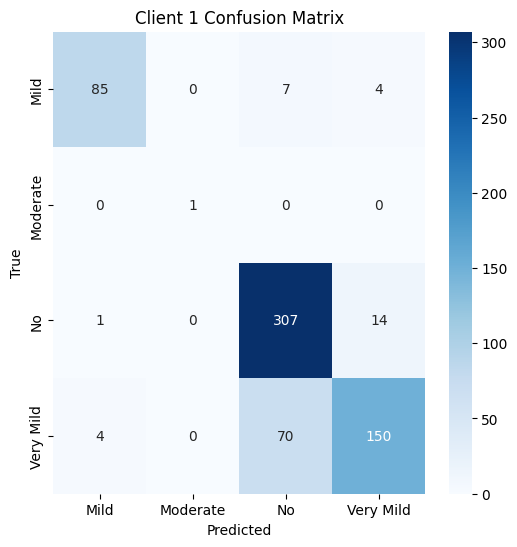


--- Results from Client 2 (640 examples) ---
  Loss: 0.3428
  Accuracy: 0.8672


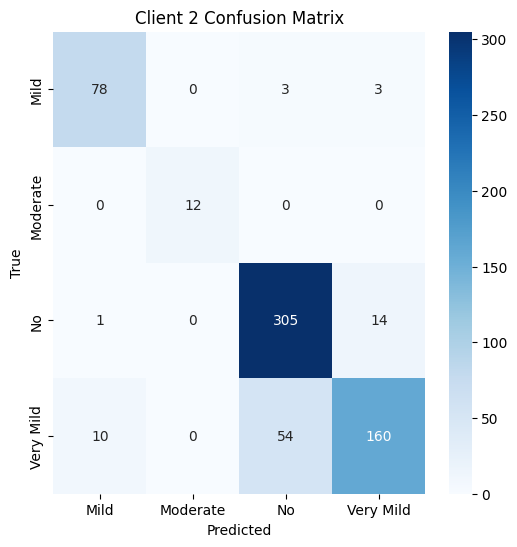

INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 87.99s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.8797696649981771
INFO :      		round 2: 0.6128024998253803
INFO :      		round 3: 0.36626573960389
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.5401403051006172),
INFO :      	              (2, 0.7053780209618625),
INFO :      	              (3, 0.8558067129351437)],
INFO :      	 'loss': [(1, 0.8797696649981771),
INFO :      	          (2, 0.6128024998253803),
INFO :      	          (3, 0.36626573960389)]}
INFO :      



📊 Round 3 AGGREGATED: loss=0.3663, acc=0.8558, time=26.88s
✅ Server finished training.
💾 Saving final global model...


✅ Model saved to federated_model.h5


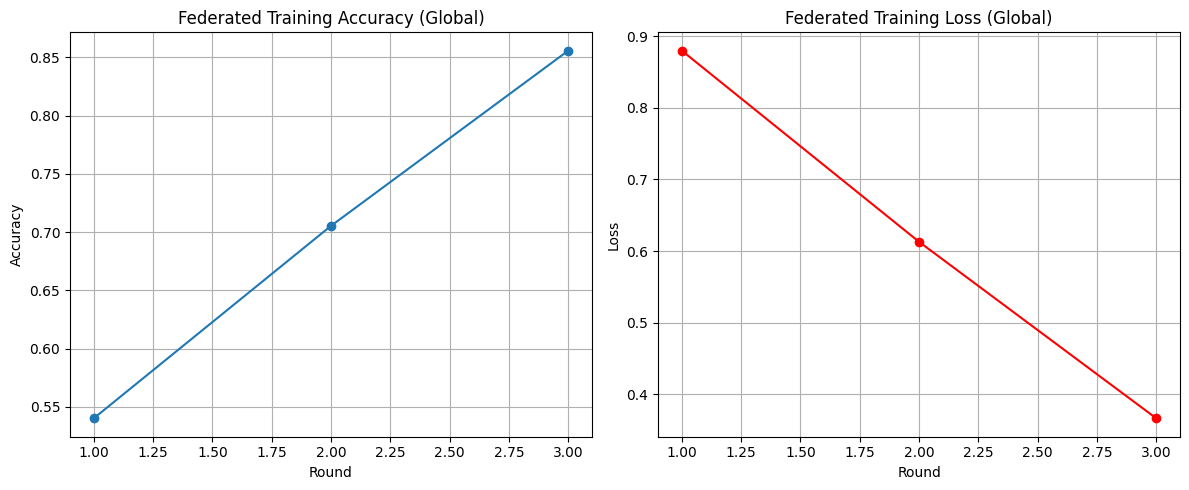

In [1]:
import flwr as fl
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn as sns
from typing import List, Tuple, Optional
from flwr.common import Metrics, Parameters, parameters_to_ndarrays
from tensorflow.keras import models, layers

# ============================================================
# 1. Imports and Global Variables
# ============================================================
history = {
    "round": [],
    "accuracy": [],
    "loss": [],
    "time": [],
}
_round_start_time = None
# This will hold the final model parameters
final_parameters: Optional[Parameters] = None 

print("✅ Imports loaded. Ready to run server code.")

# ============================================================
# 2. Model Definition (Must be same as client)
# ============================================================
def create_cnn_model():
    """Creates a memory-efficient CNN model.
    This is needed on the server to reconstruct the model before saving.
    """
    model = models.Sequential([
        layers.Input(shape=(128, 128, 3)),
        layers.Conv2D(16, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(4, activation='softmax')
    ])
    # No need to compile the model on the server for saving weights
    return model

# ============================================================
# 3. Custom Aggregation Function
# ============================================================
def evaluate_metrics_aggregation_fn(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregates evaluation metrics and displays per-client results."""
    global _round_start_time
    round_time = time.time() - _round_start_time
    history["time"].append(round_time)
    
    class_names = ["Mild", "Moderate", "No", "Very Mild"]
    for i, (num_examples, m) in enumerate(metrics):
        print(f"\n--- Results from Client {i+1} ({num_examples} examples) ---")
        print(f"  Loss: {m['loss']:.4f}")
        print(f"  Accuracy: {m['accuracy']:.4f}")
        cm_string, num_classes = m.get("confusion_matrix_str"), m.get("num_classes")
        if cm_string and num_classes:
            cm_flat = [int(i) for i in cm_string.split(',')]
            cm = np.array(cm_flat).reshape((num_classes, num_classes))
            plt.figure(figsize=(6, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                        xticklabels=class_names, yticklabels=class_names)
            plt.title(f"Client {i+1} Confusion Matrix")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.show()

    total_examples = sum(num_examples for num_examples, _ in metrics)
    weighted_loss = sum(num_examples * m["loss"] for num_examples, m in metrics) / total_examples
    weighted_acc = sum(num_examples * m["accuracy"] for num_examples, m in metrics) / total_examples
    
    round_number = len(history["round"]) + 1
    history["round"].append(round_number)
    history["loss"].append(weighted_loss)
    history["accuracy"].append(weighted_acc)
    print(f"\n📊 Round {round_number} AGGREGATED: loss={weighted_loss:.4f}, acc={weighted_acc:.4f}, time={round_time:.2f}s")
    
    return {"loss": weighted_loss, "accuracy": weighted_acc}

# ============================================================
# 4. Custom Strategy to Capture Final Model
# ============================================================
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def configure_fit(self, server_round, parameters, client_manager):
        """Set the start time for the round."""
        global _round_start_time
        _round_start_time = time.time()
        return super().configure_fit(server_round, parameters, client_manager)

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[BaseException],
    ) -> Tuple[Optional[Parameters], dict]:
        """Aggregate training results and save the final model parameters."""
        # Call the parent aggregate_fit to get the new global model's parameters
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)
        
        if aggregated_parameters is not None:
            # Save the final aggregated parameters
            print(f"✅ Round {server_round}: Saving final aggregated parameters...")
            global final_parameters
            final_parameters = aggregated_parameters
            
        return aggregated_parameters, aggregated_metrics

# ============================================================
# 5. Define and Start the Server
# ============================================================
strategy = SaveModelStrategy(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=2,
    min_evaluate_clients=2,
    min_available_clients=2,
    evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
)

print("✅ Strategy defined.")
print("🚀 Starting Flower Server...")

fl.server.start_server(
    server_address="0.0.0.0:8080",
    strategy=strategy,
    config=fl.server.ServerConfig(num_rounds=3),
)

# ============================================================
# 6. Save Final Model and Plot History
# ============================================================
print("✅ Server finished training.")

if final_parameters is not None:
    print("💾 Saving final global model...")
    # Convert parameters to NumPy arrays
    final_weights = parameters_to_ndarrays(final_parameters)
    
    # Create a new model instance and set the final weights
    final_model = create_cnn_model()
    final_model.set_weights(final_weights)
    
    # Save the model
    final_model.save("federated_model.h5")
    print("✅ Model saved to federated_model.h5")
else:
    print("⚠ Error: Final parameters not received. Model not saved.")

if len(history["round"]) > 0:
    # Plotting code remains the same...
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["round"], history["accuracy"], marker="o")
    plt.title("Federated Training Accuracy (Global)")
    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(history["round"], history["loss"], marker="o", color="red")
    plt.title("Federated Training Loss (Global)")
    plt.xlabel("Round")
    plt.ylabel("Loss")
    plt.grid()
    plt.tight_layout()
    plt.show()
else:
    print("⚠ No metrics available to plot.")